# Import Packages

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from ovm.monetary.model import MonetaryModel

import logging
import random
import typing as tp

import line_profiler
import matplotlib.pyplot as plt
%matplotlib inline
from mesa.datacollection import DataCollector
from mesa.visualization.ModularVisualization import ModularServer
from mesa.visualization.modules import ChartModule
from tqdm import tqdm

from ovm.monetary.agents import (
    MonetaryAgent, 
    MonetaryArbitrageur, 
    MonetaryKeeper
)

from ovm.monetary.markets import MonetaryFMarket
from ovm.monetary.model import MonetaryModel
from ovm.monetary.options import DataCollectionOptions
from ovm.monetary.plot_labels import (
    price_deviation_label,
    spot_price_label,
    futures_price_label,
    skew_label,
    inventory_wealth_ovl_label,
    inventory_wealth_usd_label,
    GINI_LABEL,
    GINI_ARBITRAGEURS_LABEL,
    SUPPLY_LABEL,
    TREASURY_LABEL,
    LIQUIDITY_LABEL, 
)

from ovm.monetary.reporters import *enabled 
from ovm.monetary.data_io import construct_ticker_to_series_of_prices_map

from ovm.tickers import (
    ETH_USD_TICKER,
    COMP_USD_TICKER,
    LINK_USD_TICKER,
    YFI_USD_TICKER
)

from ovm.time_resolution import TimeResolution
DEFAULT_FIGURE_SIZE = (16, 9)

In [3]:
logger = logging.getLogger(__name__)
logger.level

0

In [4]:
logging.getLevelName(logging.root.level)

'WARNING'

In [5]:
logging.root.level

30

In [6]:
%load_ext line_profiler

# Set Parameters

In [7]:
# 200000 steps corresponds to about 1.14 months
# 200000 * 15 / 60 / 60 / 24 / 365.25 * 12 = 1.14077116131
# number_of_steps_to_simulate = 200000


# number_of_steps_to_simulate = 1000

# 700000 steps corresponds to about 4 months (i.e. 1/3 year with 15 seconds per step)
# 700000 * 15 / 60 / 60 / 24 / 365.25 = 0.33272492204
number_of_steps_to_simulate = 700000

TIME_RESOLUTION = TimeResolution.FIFTEEN_SECONDS
DATA_SIM_RNG = 42

TICKERS = [ETH_USD_TICKER,
           # not a long history of simulation (can we use a different token instead)
           COMP_USD_TICKER,
           # not a long history of simulation (can we use a different token instead)
           LINK_USD_TICKER,
           # less than half a year of simulation (can we use a different token instead)
           YFI_USD_TICKER
           ]

OVL_USD_REPLACEMENT_TICKER = 'YFI-USD'
OVL_USD_TICKER = 'OVL-USD'

TICKERS_WITH_OVL = [OVL_USD_TICKER if ticker == OVL_USD_REPLACEMENT_TICKER else ticker for ticker in TICKERS]
TICKERS_WITH_OVL

['ETH-USD', 'COMP-USD', 'LINK-USD', 'OVL-USD']

In [8]:
# skew_labels = [skew_label(ticker) for ticker in TICKERS]
# skew_labels

# Load Data

In [9]:
ticker_to_time_series_of_prices_map = \
    construct_ticker_to_series_of_prices_map(data_sim_rng=DATA_SIM_RNG,
                                             time_resolution=TIME_RESOLUTION,
                                             tickers=TICKERS, 
                                             ovl_ticker=OVL_USD_REPLACEMENT_TICKER)

In [10]:
len(ticker_to_time_series_of_prices_map[ETH_USD_TICKER])

704946

In [11]:
# """
# Configure visualization elements and instantiate a server
# """


# def random_color():
#     return '#%02X%02X%02X' % (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))



# Constants
STEPS_MONTH = int((86400*30) / TIME_RESOLUTION.in_seconds)



total_supply = 100000  # OVL
base_wealth = 0.0001*100000  # OVL
# base_wealth = 0.0005*100000  # OVL
base_market_fee = 0.0030
base_max_leverage = 10.0
time_liquidity_mine = STEPS_MONTH

# For the first 30 days, emit until reach 100% of total supply; ONLY USE IN LIQUDITIY FOR NOW JUST AS TEST!
liquidity_supply_emission = [(0.51*total_supply/time_liquidity_mine)*i + 0.285*total_supply
                             for i
                             in range(time_liquidity_mine)]

num_arbitrageurs = \
    min(max(len(ticker_to_time_series_of_prices_map.keys()) * 5, 
            int(total_supply*0.01/base_wealth)), 
        100)
num_keepers = max(len(ticker_to_time_series_of_prices_map.keys()), int(total_supply * 0.005 / base_wealth))
# num_traders = min(int(total_supply*0.2/base_wealth), 100)
num_traders = 0
# num_holders = min(int(total_supply*0.5/base_wealth), 100)
num_holders = 0
num_agents = num_arbitrageurs + num_keepers + num_traders + num_holders

liquidity = 0.285*total_supply
treasury = 0.0
sampling_interval = 240

# TODO: Vary these initial num_ ... numbers; for init, reference empirical #s already seeing for diff projects
MODEL_KWARGS = {
    "ticker_to_time_series_of_prices_map": ticker_to_time_series_of_prices_map,
    "num_arbitrageurs": num_arbitrageurs,
    "num_keepers": num_keepers,
    "num_traders": num_traders,
    "num_holders": num_holders,
    "base_wealth": base_wealth,
    "base_market_fee": base_market_fee,
    "base_max_leverage": base_max_leverage,
    # Setting liquidity = 100x agent-owned OVL for now; TODO: eventually have this be a function/array
    "liquidity": liquidity,
    "liquidity_supply_emission": liquidity_supply_emission,
    "treasury": treasury,
    # TODO: 1920 ... 8h with 15s blocks (sim simulation is every 15s)
    "sampling_interval": sampling_interval,
}

print("Model kwargs for initial conditions of sim:")
print(f"num_arbitrageurs = {MODEL_KWARGS['num_arbitrageurs']}")
print(f"num_keepers = {MODEL_KWARGS['num_keepers']}")
print(f"num_traders = {MODEL_KWARGS['num_traders']}")
print(f"num_holders = {MODEL_KWARGS['num_holders']}")
print(f"total number of agents = {num_agents}")
print(f"base_wealth = {MODEL_KWARGS['base_wealth']}")


data_collection_options = \
    DataCollectionOptions(perform_data_collection=True, 
                          compute_gini_coefficient=False,
                          compute_wealth=False,
                          compute_inventory_wealth=False)


monetary_model = \
    MonetaryModel(num_arbitrageurs=num_arbitrageurs, 
                  num_keepers=num_keepers, 
                  num_traders=num_traders, 
                  num_holders=num_holders, 
                  ticker_to_time_series_of_prices_map=ticker_to_time_series_of_prices_map, 
                  base_wealth=base_wealth, 
                  base_market_fee=base_market_fee, 
                  base_max_leverage=base_max_leverage, 
                  liquidity=liquidity, 
                  liquidity_supply_emission=liquidity_supply_emission, 
                  treasury=treasury, 
                  sampling_interval=sampling_interval, 
                  data_collection_options=data_collection_options)

Model kwargs for initial conditions of sim:
num_arbitrageurs = 100
num_keepers = 50
num_traders = 0
num_holders = 0
total number of agents = 150
base_wealth = 10.0


Drastically reduced the number of traders and holders to bring down the memory requirement for storing agent wealth (with the original numbers it would have been 7500 agents total). This would exceed the 128GB mem of my machine with 200000 steps

In [12]:
for i in tqdm(range(number_of_steps_to_simulate)):
    monetary_model.step()

100%|██████████| 700000/700000 [04:21<00:00, 2672.39it/s]


In [13]:
def run_model(number_of_steps_to_simulate: int):
    for i in range(number_of_steps_to_simulate):
        monetary_model.step()

In [14]:
# %lprun \
#     -f compute_gini \
#     -f compute_price_difference \
#     -f compute_futures_price \
#     -f compute_spot_price \
#     -f compute_supply \
#     -f compute_liquidity \
#     -f compute_treasury \
#     -f compute_wealth_for_agent_type \
#     -f compute_inventory_wealth_for_agent \
#     -f compute_inventory_wealth_for_agent_type \
#     -f compute_positional_imbalance_by_market \
#     -f DataCollector.collect \
#     -f MonetaryAgent.step \
#     -f MonetaryArbitrageur._unwind_positions \
#     -f MonetaryArbitrageur._unwind_next_position \
#     -f MonetaryArbitrageur.trade \
#     -f MonetaryArbitrageur.step \
#     -f MonetaryKeeper.step \
#     -f MonetaryKeeper.distribute_funding \
#     -f MonetaryFMarket.build \
#     -f MonetaryFMarket.unwind \
#     -f MonetaryFMarket._swap \
#     -f MonetaryFMarket.fund \
#     -f MonetaryModel.step \
#     run_model(number_of_steps_to_simulate)

In [15]:
model_vars_df = monetary_model.data_collector.get_model_vars_dataframe()
model_vars_df.head()

,d-ETH-USD,d-COMP-USD,d-LINK-USD,d-OVL-USD,s-ETH-USD,s-COMP-USD,s-LINK-USD,s-OVL-USD,f-ETH-USD,f-COMP-USD,f-LINK-USD,f-OVL-USD,Skew ETH-USD,Skew COMP-USD,Skew LINK-USD,Skew OVL-USD,Supply,Treasury,Liquidity
0,0.000000,0.000000,0.000000,0.000000,284.578702,157.277894,7.707481,3565.000000,284.578702,157.277894,7.707481,3565.0,0.0,0.0,0.000,0.0,30000.0000,0.0000,28500.0
1,0.000000,0.000000,0.000000,0.000000,284.578702,157.277894,7.707481,3565.000000,284.578702,157.277894,7.707481,3565.0,0.0,0.0,0.000,0.0,30000.0000,0.0000,28500.0
2,0.000069,0.000000,-0.008617,0.000000,284.559134,157.277894,7.774473,3565.000000,284.578702,157.277894,7.707481,3565.0,0.0,0.0,0.000,0.0,30000.0000,0.0000,28500.0
3,-0.000389,-0.001381,-0.015742,0.000000,284.689582,157.495320,7.830755,3565.000000,284.578702,157.277894,7.707481,3565.0,0.0,0.0,0.000,0.0,30000.0000,0.0000,28500.0
4,-0.000412,-0.001381,-0.011388,-0.016055,284.696105,157.495320,7.835585,3623.170163,284.578702,157.277894,7.746356,3565.0,0.0,0.0,8.973,0.0,29999.9865,0.0135,28500.0


In [25]:
agent_vars_df = monetary_model.data_collector.get_agent_vars_dataframe()
print(len(agent_vars_df))

In [26]:
agent_vars_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 105000000 entries, (0, 0) to (699999, 149)
Data columns (total 1 columns):
 #   Column  Dtype  
---  ------  -----  
 0   Wealth  float64
dtypes: float64(1)
memory usage: 1.4 GB


In [28]:
agent_vars_df.tail()

Wealth
Step   AgentID        
699999 145        10.0
       146        10.0
       147        10.0
       148        10.0
       149        10.0

In [30]:
agent_vars_df.loc[(699999, 1), :]
# df.loc[('cobra', 'mark i'), 'shield']

Wealth    4.088279e-18
Name: (699999, 1), dtype: float64

In [18]:
model_vars_df.memory_usage(deep=True)

Index                128
d-ETH-USD        5600008
d-COMP-USD       5600008
d-LINK-USD       5600008
d-OVL-USD        5600008
s-ETH-USD        5600008
s-COMP-USD       5600008
s-LINK-USD       5600008
s-OVL-USD        5600008
f-ETH-USD        5600008
f-COMP-USD       5600008
f-LINK-USD       5600008
f-OVL-USD        5600008
Skew ETH-USD     5600008
Skew COMP-USD    5600008
Skew LINK-USD    5600008
Skew OVL-USD     5600008
Supply           5600008
Treasury         5600008
Liquidity        5600008
dtype: int64

In [19]:
model_vars_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700001 entries, 0 to 700000
Data columns (total 19 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   d-ETH-USD      700001 non-null  float64
 1   d-COMP-USD     700001 non-null  float64
 2   d-LINK-USD     700001 non-null  float64
 3   d-OVL-USD      700001 non-null  float64
 4   s-ETH-USD      700001 non-null  float64
 5   s-COMP-USD     700001 non-null  float64
 6   s-LINK-USD     700001 non-null  float64
 7   s-OVL-USD      700001 non-null  float64
 8   f-ETH-USD      700001 non-null  float64
 9   f-COMP-USD     700001 non-null  float64
 10  f-LINK-USD     700001 non-null  float64
 11  f-OVL-USD      700001 non-null  float64
 12  Skew ETH-USD   700001 non-null  float64
 13  Skew COMP-USD  700001 non-null  float64
 14  Skew LINK-USD  700001 non-null  float64
 15  Skew OVL-USD   700001 non-null  float64
 16  Supply         700001 non-null  float64
 17  Treasury       700001 non-nul

# New Plots with 100 Arbitrageurs (no traders and no holders)

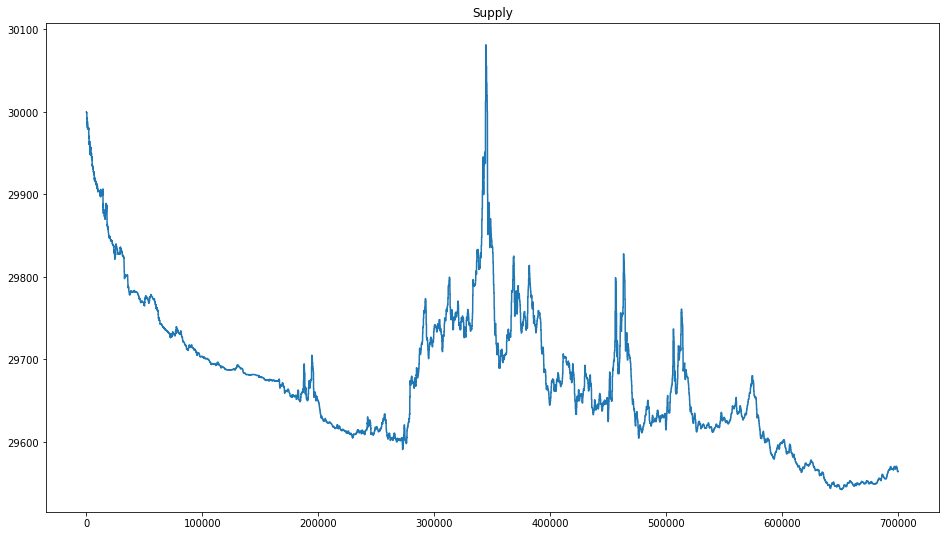

In [20]:
plt.figure(0, figsize=DEFAULT_FIGURE_SIZE);
plt.plot(model_vars_df.loc[:, SUPPLY_LABEL]);
plt.title(SUPPLY_LABEL);

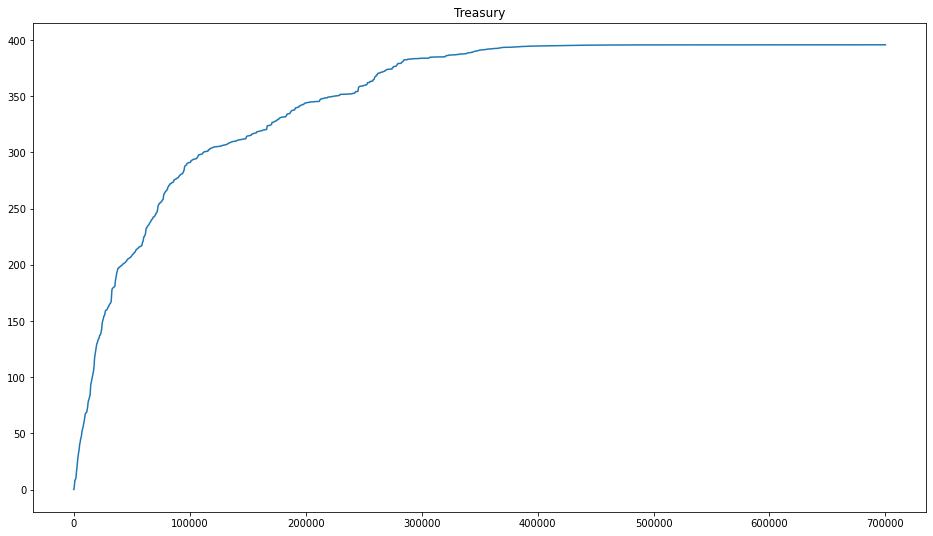

In [21]:
plt.figure(1, figsize=DEFAULT_FIGURE_SIZE);
plt.plot(model_vars_df.loc[:, TREASURY_LABEL]);
plt.title(TREASURY_LABEL);

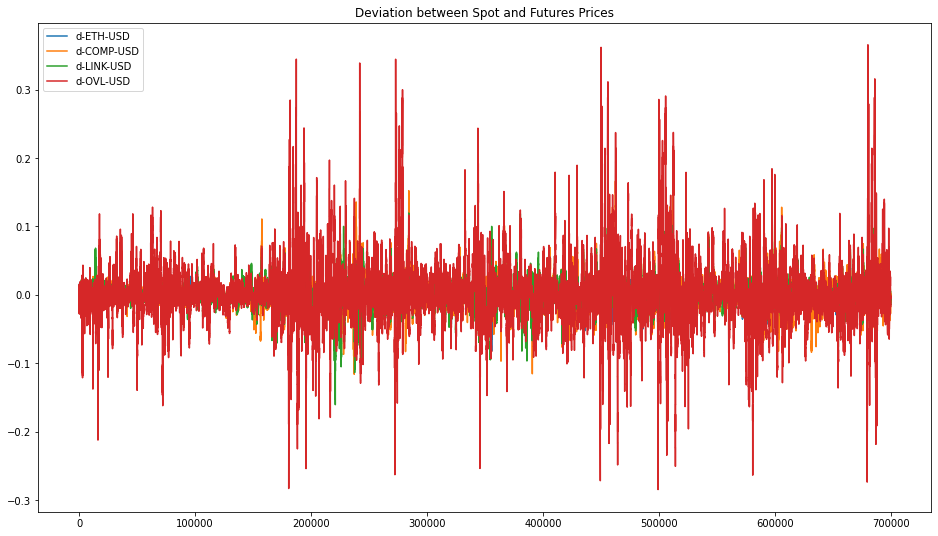

In [22]:
plt.figure(2, figsize=DEFAULT_FIGURE_SIZE);
for ticker in TICKERS_WITH_OVL:
    plt.plot(model_vars_df.loc[:, price_deviation_label(ticker)], label=price_deviation_label(ticker));
plt.legend();
plt.title('Deviation between Spot and Futures Prices');

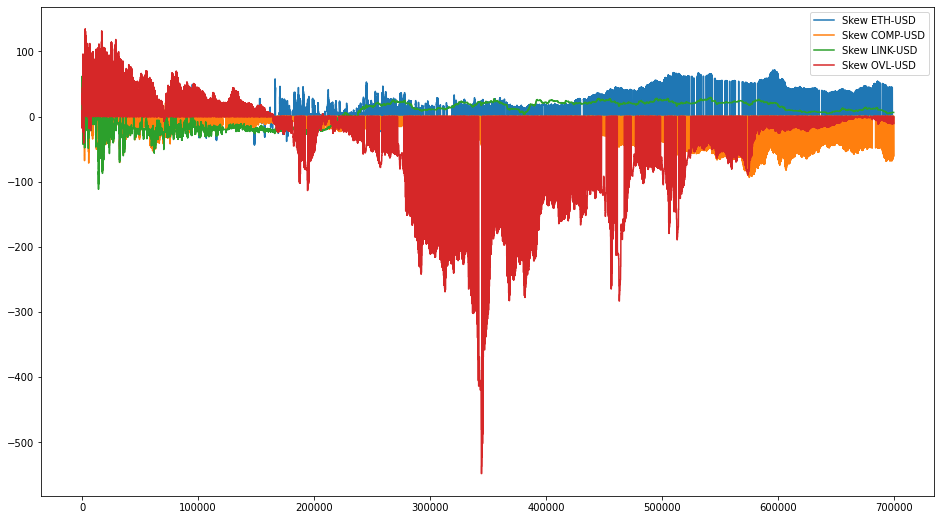

In [23]:
plt.figure(3, figsize=DEFAULT_FIGURE_SIZE);
for ticker in TICKERS_WITH_OVL:
    plt.plot(model_vars_df.loc[:, skew_label(ticker)], label=skew_label(ticker));
plt.legend();

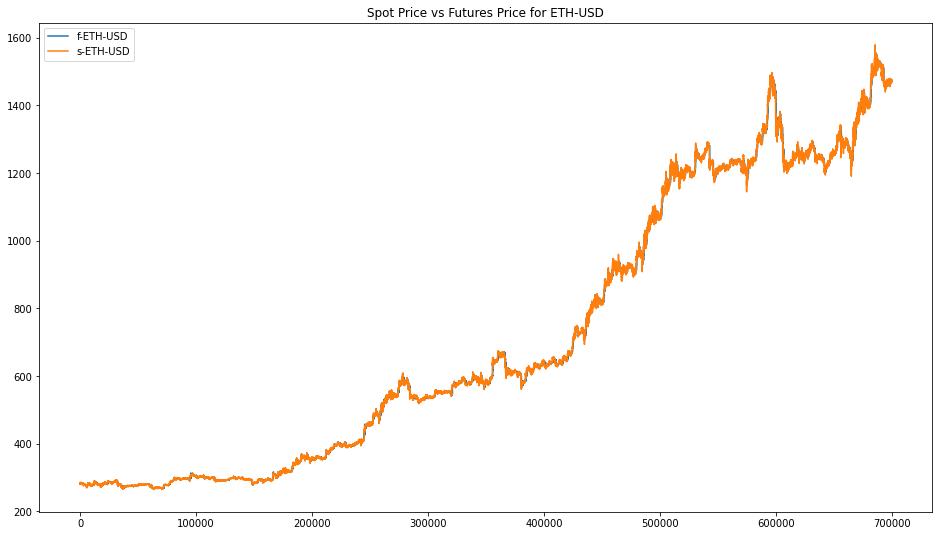

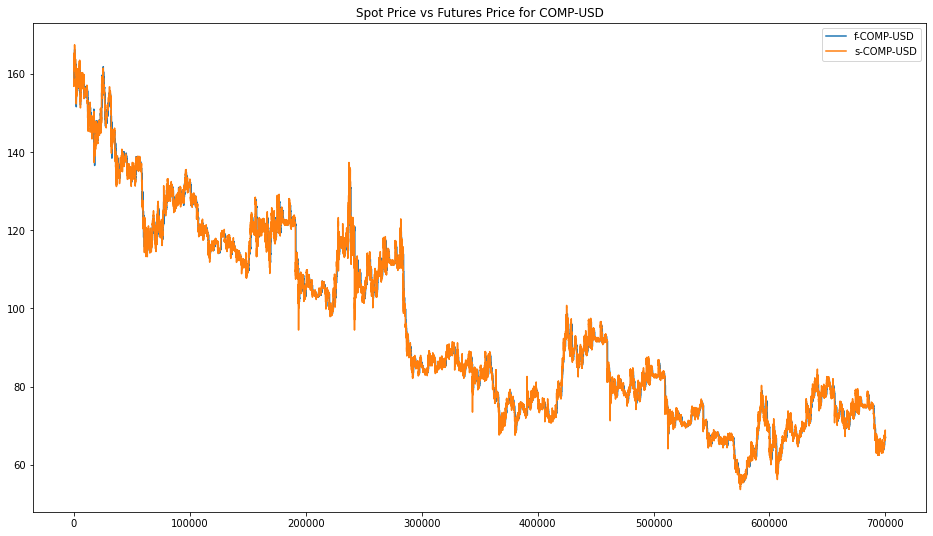

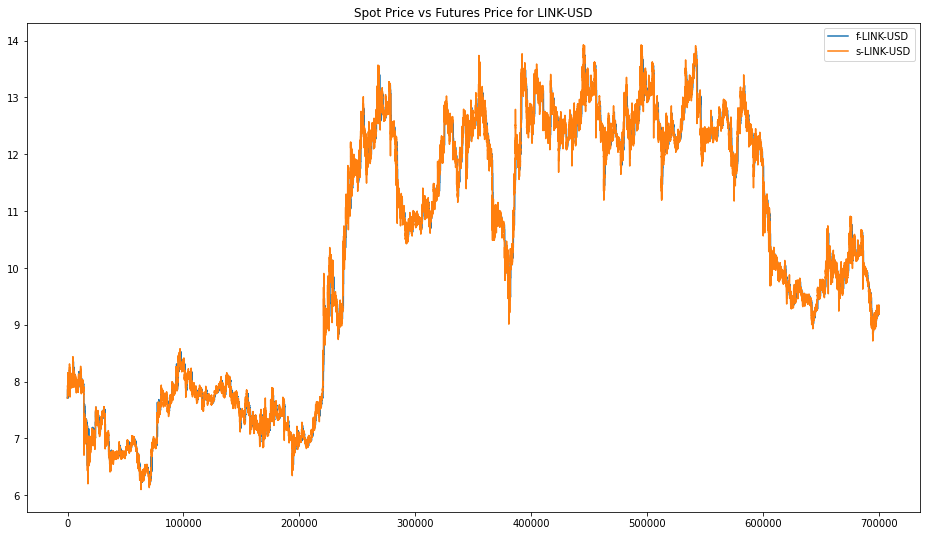

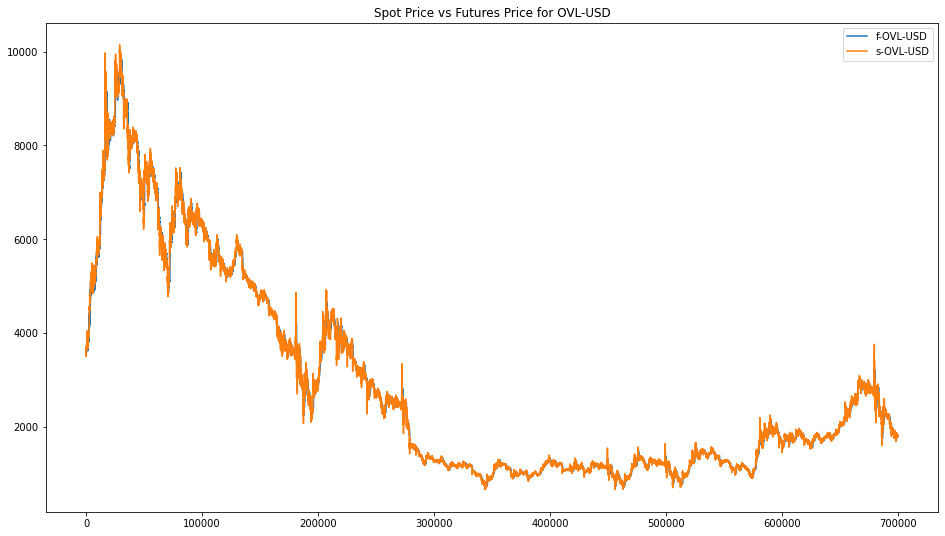

In [24]:
for i, ticker in enumerate(TICKERS_WITH_OVL):
    plt.figure(4+i, figsize=DEFAULT_FIGURE_SIZE);
    plt.plot(model_vars_df.loc[:, futures_price_label(ticker)], label=futures_price_label(ticker));
    plt.plot(model_vars_df.loc[:, spot_price_label(ticker)], label=spot_price_label(ticker));
    plt.title(f'Spot Price vs Futures Price for {ticker}')
    plt.legend();

## Old Plots with 100 Arbitrageurs

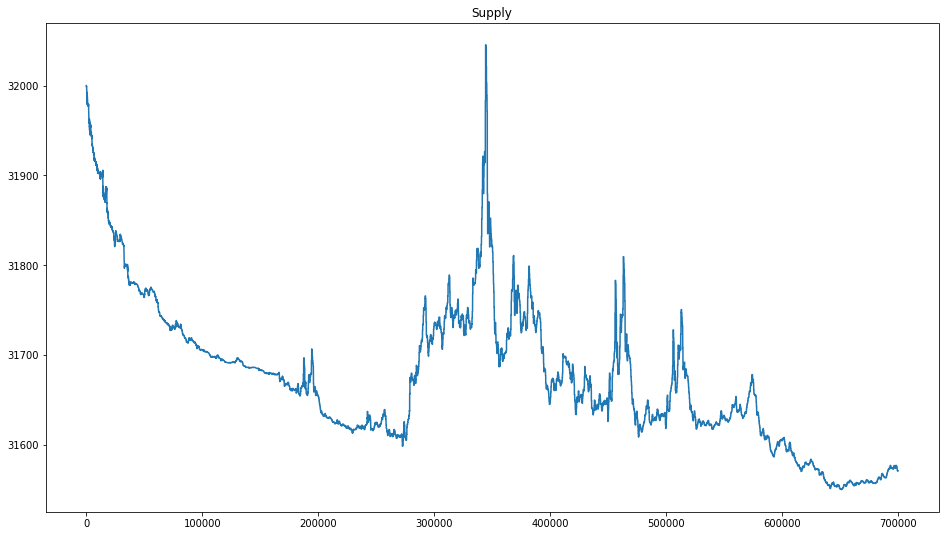

In [33]:
plt.figure(0, figsize=DEFAULT_FIGURE_SIZE);
plt.plot(model_vars_df.loc[:, SUPPLY_LABEL]);
plt.title(SUPPLY_LABEL);

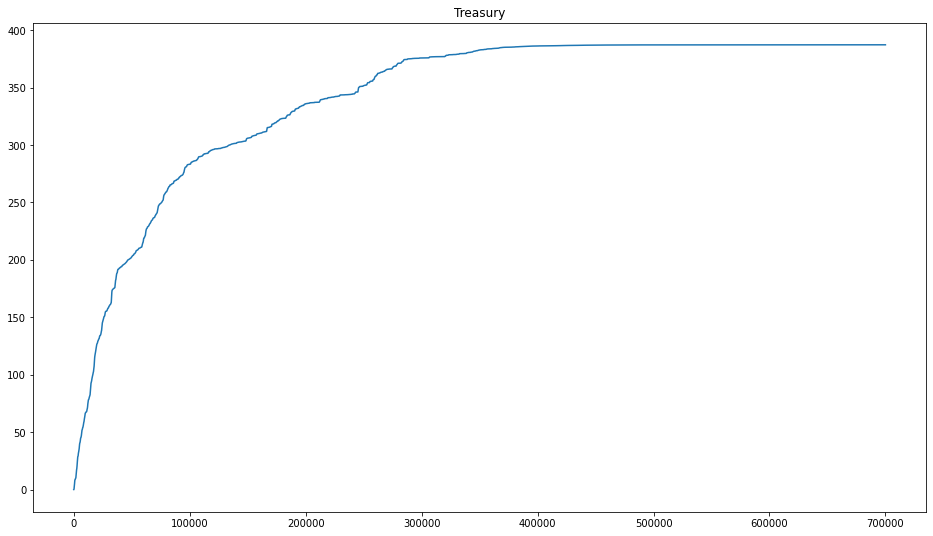

In [34]:
plt.figure(1, figsize=DEFAULT_FIGURE_SIZE);
plt.plot(model_vars_df.loc[:, TREASURY_LABEL]);
plt.title(TREASURY_LABEL);

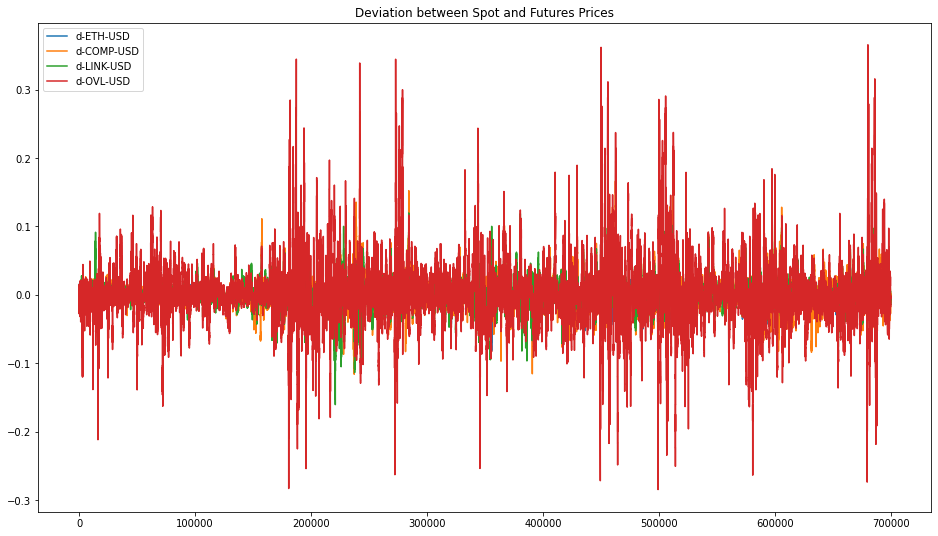

In [35]:
plt.figure(2, figsize=DEFAULT_FIGURE_SIZE);
for ticker in TICKERS_WITH_OVL:
    plt.plot(model_vars_df.loc[:, price_deviation_label(ticker)], label=price_deviation_label(ticker));
plt.legend();
plt.title('Deviation between Spot and Futures Prices');

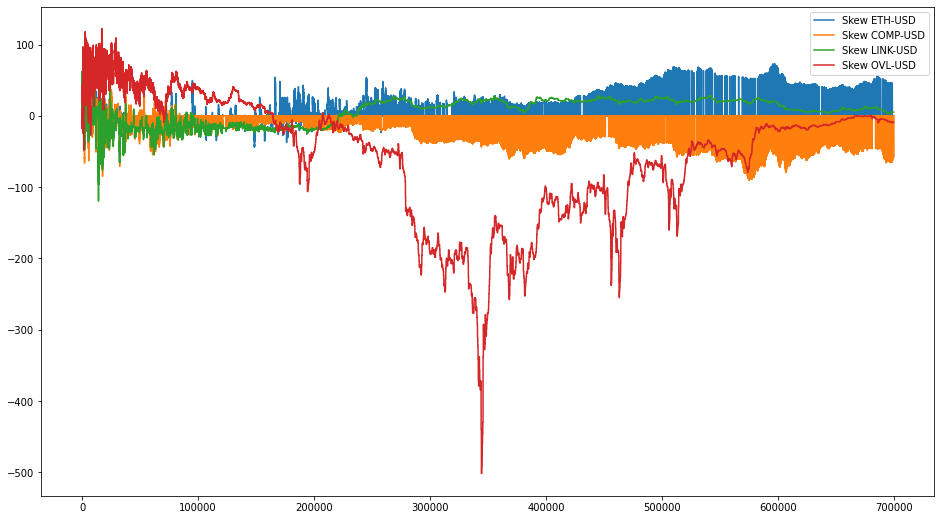

In [36]:
plt.figure(3, figsize=DEFAULT_FIGURE_SIZE);
for ticker in TICKERS_WITH_OVL:
    plt.plot(model_vars_df.loc[:, skew_label(ticker)], label=skew_label(ticker));
plt.legend();

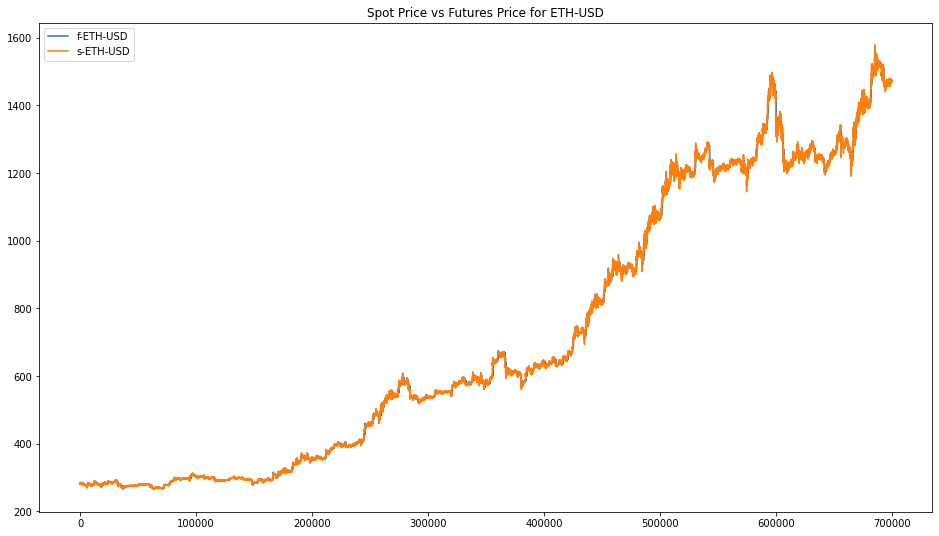

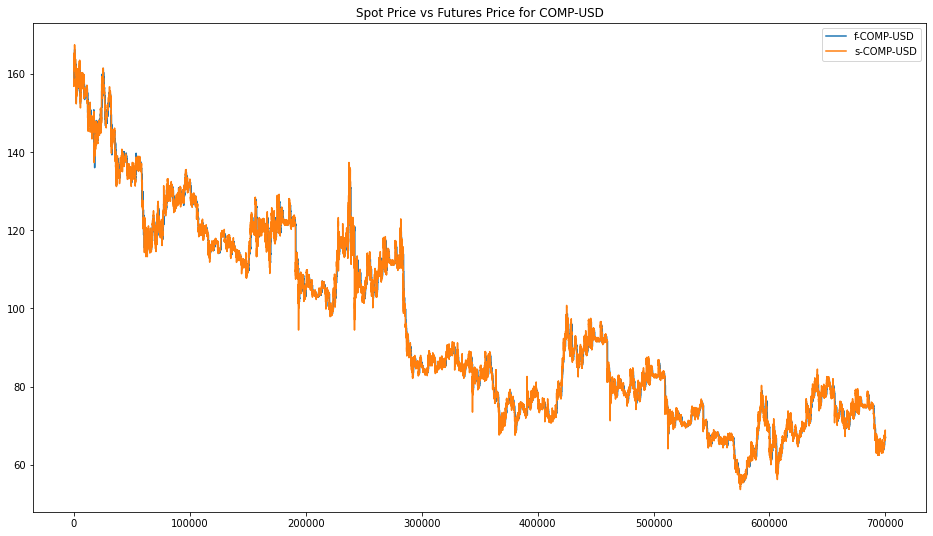

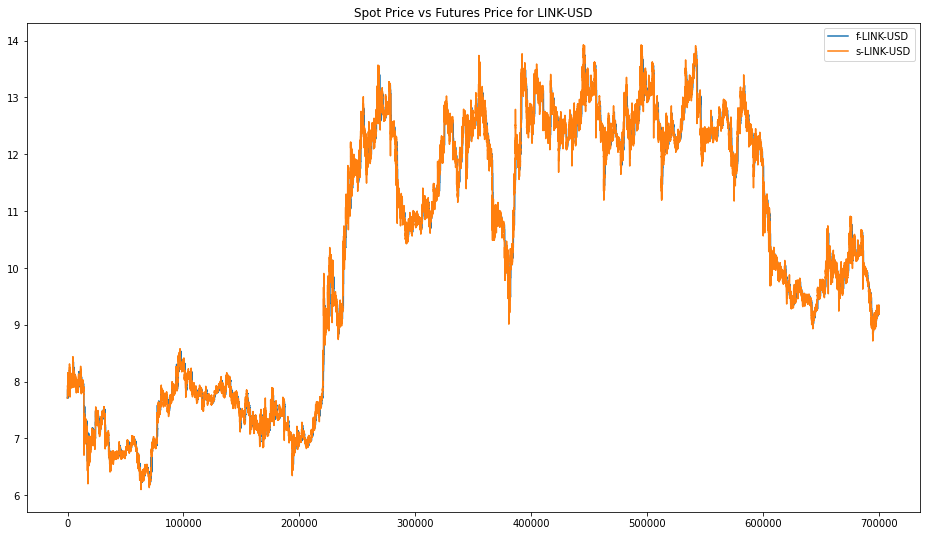

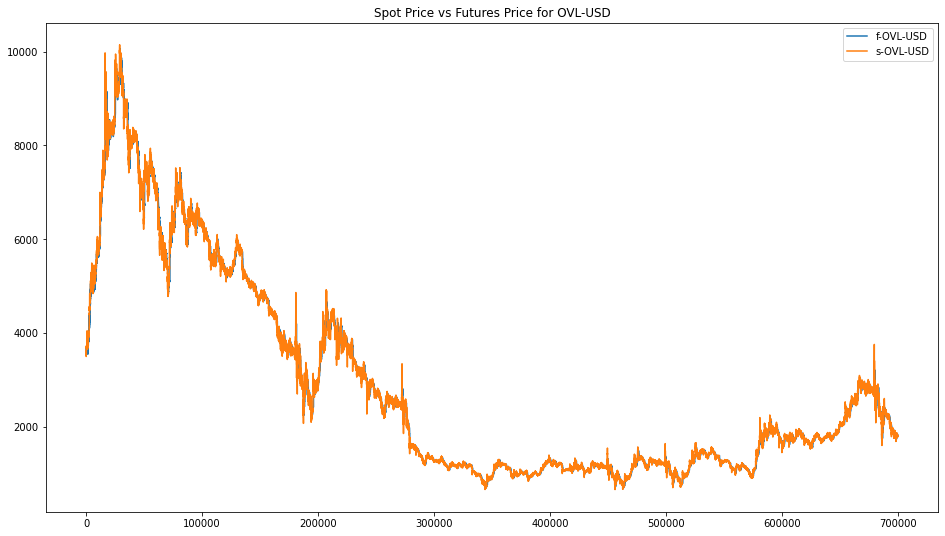

In [37]:
for i, ticker in enumerate(TICKERS_WITH_OVL):
    plt.figure(4+i, figsize=DEFAULT_FIGURE_SIZE);
    plt.plot(model_vars_df.loc[:, futures_price_label(ticker)], label=futures_price_label(ticker));
    plt.plot(model_vars_df.loc[:, spot_price_label(ticker)], label=spot_price_label(ticker));
    plt.title(f'Spot Price vs Futures Price for {ticker}')
    plt.legend();